# KIS-ORCA subsea cables

<https://kis-orca.org/>

In [1]:
import os
from datetime import datetime, timezone
from zipfile import ZipFile, BadZipFile

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pooch
import seaborn as sns
import pandas as pd

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "kis-orca")
os.makedirs(DATA_DIR, exist_ok=True)

URL = (
    "https://kis-orca.org/wp-content/uploads/2020/12/Olex_KIS-ORCA-v2023.zip"
)
KNOWN_HASH = None
FILE_NAME = "Olex_KIS-ORCA-v2023.zip"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [3]:
# download data if necessary
if not os.path.isfile(DATA_FILE):
    pooch.retrieve(
        url=URL,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=DATA_DIR
    )

    with open(f"{DATA_FILE[:-4]}.txt", "w", encoding="utf-8") as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

SHA256 hash of downloaded file: fd646e524a74fc36ee9401a0f1af6e977464ae76c6d8cc0126f4c738c6e4480a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [4]:
with open(f"{DATA_FILE[:-4]}.txt") as f:
    print(f.read())

Data downloaded on: 2023-11-12 22:35:48.040165+00:00
Download URL: https://kis-orca.org/wp-content/uploads/2020/12/Olex_KIS-ORCA-v2023.zip



## Read data

In [6]:
# extract the archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

In [3]:
DATA_FILE = os.path.join(DATA_DIR, ZipFile(DATA_FILE).namelist()[0])

In [9]:
# extract gz file
os.system(f"gzip -d < {DATA_FILE} > {DATA_FILE[:-3]}")

0

In [4]:
DATA_FILE = DATA_FILE[:-3]

In [5]:
# coordinates
with open(f"{DATA_FILE}_data.txt", "w", encoding="utf-8") as outfile:
    for n, line in enumerate(open(DATA_FILE, "r", encoding="ISO-8859-15")):
        if line[0].isdigit():
            outfile.write(f"{n} {line}")

# names
with open(f"{DATA_FILE}_names.txt", "w", encoding="utf-8") as outfile:
    for n, line in enumerate(open(DATA_FILE, "r", encoding="ISO-8859-15")):
        if "MTekst 2" in str(line):
            outfile.write(f"{n}, {line[18:]}")

In [6]:
data = pd.read_csv(
    f"{DATA_FILE}_data.txt", header=None, sep=" ",
    names=["y", "x", "z", "text"]
)

names = pd.read_csv(
    f"{DATA_FILE}_names.txt", header=None, names=["index", "name"]
)

In [7]:
data.head()

,y,x,z,text
3,3052.588,-291.958,1675123200,Gulramme
14,3059.834,-325.624,1675123200,Gulramme
25,3060.112,-361.904,1675123200,Gulramme
36,3060.160,-404.239,1675123200,Gulramme
47,3059.491,-424.326,1675123200,Gulramme


In [8]:
data.shape

(442011, 4)

In [9]:
names.head()

,index,name
0,7,APOLLO NORTH
1,18,APOLLO NORTH
2,29,APOLLO NORTH
3,40,APOLLO NORTH
4,51,APOLLO NORTH


In [10]:
names.shape

(21647, 2)

In [11]:
names.set_index("index", inplace=True)

## Merge names with coordinates

**IMPORTANT:** There may be some incorrect name assignments as a simple
backfill was used and no further checks were done

In [12]:
names = names.reindex(range(max(data.index) + 1))

In [13]:
# handle missing data with backfill / forward fill
names = names.bfill()
names = names.ffill()

In [14]:
names.head()

,name
index,
0,APOLLO NORTH
1,APOLLO NORTH
2,APOLLO NORTH
3,APOLLO NORTH
4,APOLLO NORTH


In [15]:
names.shape

(657317, 1)

In [16]:
# merge names and data
data = pd.merge(data, names, left_index=True, right_index=True)

In [17]:
data.head()

,y,x,z,text,name
3,3052.588,-291.958,1675123200,Gulramme,APOLLO NORTH
14,3059.834,-325.624,1675123200,Gulramme,APOLLO NORTH
25,3060.112,-361.904,1675123200,Gulramme,APOLLO NORTH
36,3060.160,-404.239,1675123200,Gulramme,APOLLO NORTH
47,3059.491,-424.326,1675123200,Gulramme,APOLLO NORTH


In [18]:
data.shape

(442011, 5)

## Convert to geodataframe

In [19]:
# drop duplicate entries using coordinates
data = data.drop_duplicates(["y", "x"])

In [20]:
data.shape

(419079, 5)

In [21]:
# https://gis.stackexchange.com/a/241922
# convert coords from minutes to degrees
data["x"] = data["x"] / 60
data["y"] = data["y"] / 60

In [22]:
data.head()

,y,x,z,text,name
3,50.876467,-4.865967,1675123200,Gulramme,APOLLO NORTH
14,50.997233,-5.427067,1675123200,Gulramme,APOLLO NORTH
25,51.001867,-6.031733,1675123200,Gulramme,APOLLO NORTH
36,51.002667,-6.737317,1675123200,Gulramme,APOLLO NORTH
47,50.991517,-7.072100,1675123200,Gulramme,APOLLO NORTH


In [23]:
# convert to geodataframe
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.x, data.y, crs=4326)
)

In [24]:
data.head()

,y,x,z,text,name,geometry
3,50.876467,-4.865967,1675123200,Gulramme,APOLLO NORTH,POINT (-4.86597 50.87647)
14,50.997233,-5.427067,1675123200,Gulramme,APOLLO NORTH,POINT (-5.42707 50.99723)
25,51.001867,-6.031733,1675123200,Gulramme,APOLLO NORTH,POINT (-6.03173 51.00187)
36,51.002667,-6.737317,1675123200,Gulramme,APOLLO NORTH,POINT (-6.73732 51.00267)
47,50.991517,-7.072100,1675123200,Gulramme,APOLLO NORTH,POINT (-7.07210 50.99152)


In [25]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

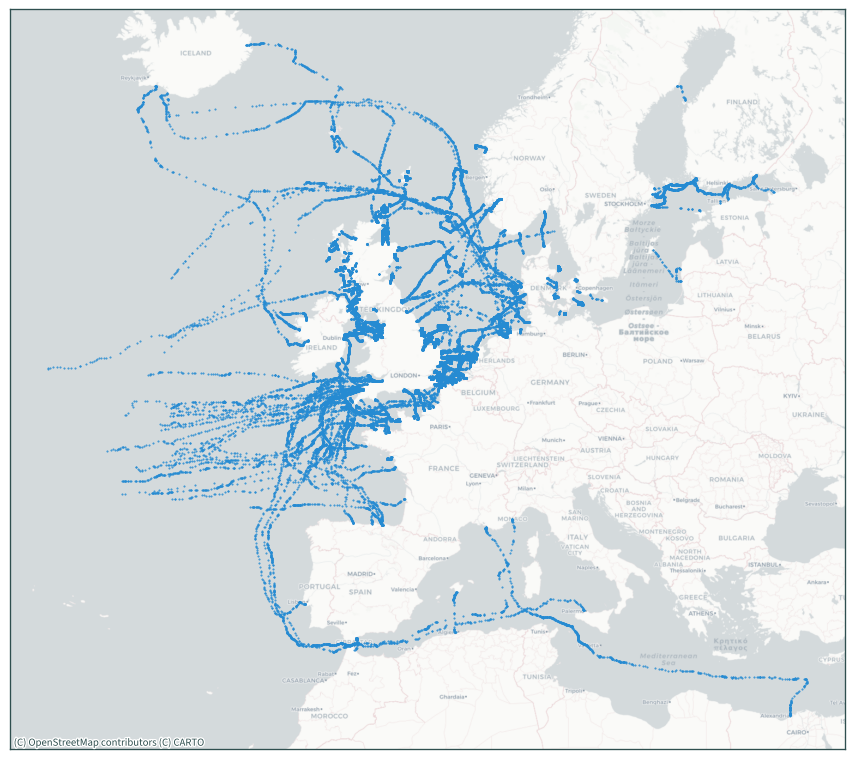

In [26]:
ax = data.to_crs(3857).plot(marker=".", markersize=1, figsize=(9, 9))
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

## Dissolve geometries

In [27]:
# dissolve by name
data = data.dissolve("name").reset_index()

In [28]:
data.head()

,name,geometry,y,x,z,text
0,50m Fishing Advisory Safety Zone ABERDEEN WIN...,"MULTIPOINT (-2.06615 57.21560, -2.06615 57.215...",57.215867,-2.063850,1675123200,Brunsirkel
1,50m Fishing Advisory Safety Zone ANHOLT WIND ...,"MULTIPOINT (-1.98668 57.21603, -1.98667 57.216...",57.216033,-1.986683,1675123200,Brunsirkel
2,50m Fishing Advisory Safety Zone BARROW WIND ...,"MULTIPOINT (-3.32998 53.99517, -3.32998 53.995...",56.676350,11.160500,1675123200,Brunsirkel
3,50m Fishing Advisory Safety Zone BEATRICE WIN...,"MULTIPOINT (-3.29142 53.98413, -3.29140 53.984...",53.984133,-3.291417,1675123200,Brunsirkel
4,50m Fishing Advisory Safety Zone BLYTH DEMO P...,"MULTIPOINT (-2.89668 58.25688, -2.89668 58.256...",58.256883,-2.896683,1675123200,Brunsirkel


In [29]:
data.shape

(6126, 6)

## Data for the Irish Sea

In [64]:
# extent
mask = (-7, 53, -4.5, 54)

In [65]:
data_ie = data.clip(mask)

In [66]:
data_ie

,name,geometry,y,x,z,text
2139,HIBERNIA ATLANTIC SEG.D TELECOM CABLE,"MULTIPOINT (-6.12517 53.39633, -6.12417 53.397...",53.402833,-6.104000,1675123200,Brunsirkel
902,CELTIC TELECOM CABLE,"MULTIPOINT (-5.03608 53.37180, -5.03058 53.36447)",53.371800,-5.036083,1675123200,Brunsirkel
1295,ESAT 2 TELECOM CABLE,"MULTIPOINT (-6.20643 53.32382, -6.20222 53.324...",50.088667,-5.710950,1675123200,Brunsirkel
2135,HIBERNIA ATLANTIC,"MULTIPOINT (-6.01117 53.43167, -5.97792 53.347...",53.893500,-4.318000,1675123200,Rødramme
4794,ROCKABILL TELECOM CABLE,"MULTIPOINT (-6.10937 53.49357, -6.10557 53.493...",51.423183,1.616950,1675123200,Brunsirkel
6113,WESTERN LINK ARDNEILL TO WIRRAL 1 POWER CABLE,"MULTIPOINT (-5.10547 53.94238, -5.10395 53.939...",51.085450,1.220567,1675123200,Brunsirkel
1288,EMERALD BRIDGE,POINT (-4.95258 53.28408),53.284083,-4.952583,1675123200,Rødramme
1294,ESAT 2,"MULTIPOINT (-6.04087 53.34388, -6.02700 53.34995)",53.343883,-6.040867,1675123200,Rødramme
5019,SIRIUS SOUTH,"MULTIPOINT (-5.96933 53.47467, -5.64117 53.556...",53.731500,-3.591333,1675123200,Rødramme
2137,HIBERNIA ATLANTIC SEG.A TELECOM CABLE,"MULTIPOINT (-5.07918 53.95348, -5.07802 53.948...",51.740550,1.289317,1675123200,Brunsirkel


In [67]:
data_ie.shape

(26, 6)

In [68]:
# convert all multi points to multi lines
data_ie_1 = data_ie[
    data_ie["geometry"].astype(str).str.contains("MULTI")
].reset_index(drop=True)

data_ie_1["geometry"] = gpd.GeoSeries.from_wkt(
    "LINESTRING ("
    + data_ie_1["geometry"].astype(str).str.split("(", expand=True)[1],
    crs=4326
)

In [69]:
# merge multi lines with any remaining point / other data
data_ie = pd.concat(
    [
        data_ie[~data_ie["geometry"].astype(str).str.contains("MULTI")],
        data_ie_1
    ]
).reset_index(drop=True)

In [70]:
data_ie

,name,geometry,y,x,z,text
0,EMERALD BRIDGE,POINT (-4.95258 53.28408),53.284083,-4.952583,1675123200,Rødramme
1,DOGGER BANK A WF EXTENT,POINT (-6.12470 53.43220),53.432200,-6.124700,1675123200,Brunsirkel
2,HAVHINGSTEN SEG 2.1 TELECOM CABLE,POINT (-4.57918 53.84250),53.842500,-4.579183,1675123200,Brunsirkel
3,HIBERNIA ATLANTIC SEG.D TELECOM CABLE,"LINESTRING (-6.12517 53.39633, -6.12417 53.397...",53.402833,-6.104000,1675123200,Brunsirkel
4,CELTIC TELECOM CABLE,"LINESTRING (-5.03608 53.37180, -5.03058 53.36447)",53.371800,-5.036083,1675123200,Brunsirkel
5,ESAT 2 TELECOM CABLE,"LINESTRING (-6.20643 53.32382, -6.20222 53.324...",50.088667,-5.710950,1675123200,Brunsirkel
6,HIBERNIA ATLANTIC,"LINESTRING (-6.01117 53.43167, -5.97792 53.347...",53.893500,-4.318000,1675123200,Rødramme
7,ROCKABILL TELECOM CABLE,"LINESTRING (-6.10937 53.49357, -6.10557 53.493...",51.423183,1.616950,1675123200,Brunsirkel
8,WESTERN LINK ARDNEILL TO WIRRAL 1 POWER CABLE,"LINESTRING (-5.10547 53.94238, -5.10395 53.939...",51.085450,1.220567,1675123200,Brunsirkel
9,ESAT 2,"LINESTRING (-6.04087 53.34388, -6.02700 53.34995)",53.343883,-6.040867,1675123200,Rødramme


In [71]:
# get bounds of Irish Sea data
xmin, ymin, xmax, ymax = data_ie.to_crs(23029).total_bounds

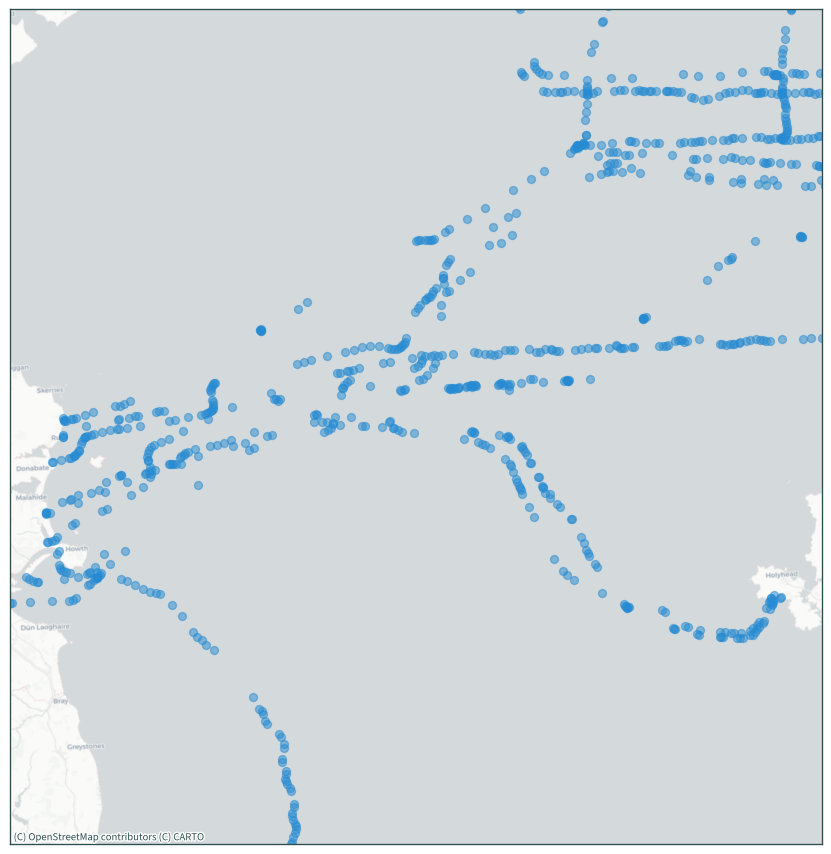

In [72]:
# view plotter points in the Irish Sea
ax = data.to_crs(23029).plot(alpha=.5, figsize=(9, 9))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=23029)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

**IMPORTANT:** There may be some incorrect name assignments as a simple
backfill was used and no further checks were done

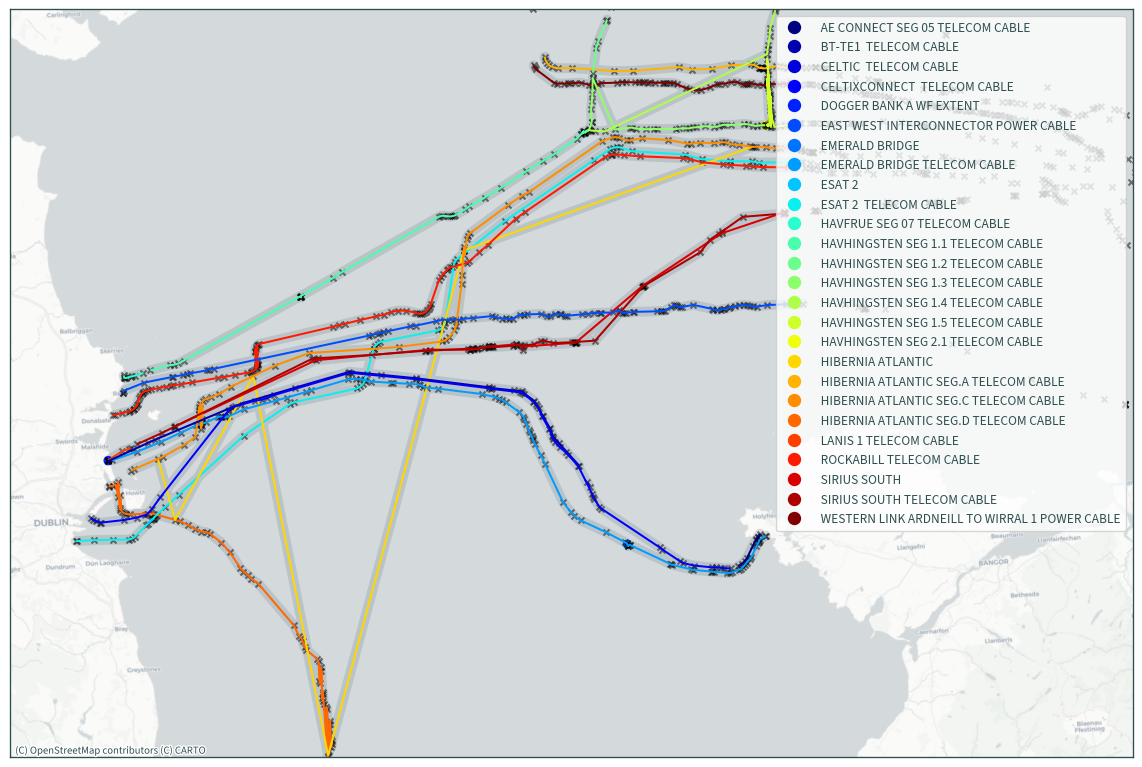

In [73]:
ax = gpd.GeoDataFrame(
    geometry=data_ie.to_crs(23029).buffer(750)
).dissolve().plot(figsize=(12, 12), alpha=.25, color="slategrey")
data_ie.to_crs(23029).plot(
    column="name", legend=True, ax=ax, cmap="jet",
    legend_kwds={"loc": "upper right"}
)
data.to_crs(23029).plot(
    ax=ax, marker="x", color="black", markersize=20, alpha=.5
)
plt.xlim(xmin - 10000, xmax + 50000)
plt.ylim(ymin, ymax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=23029)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [74]:
# remove incorrect data lines - Hibernia Atlantic
data_ie = data_ie.drop([6]).reset_index(drop=True)

**IMPORTANT:** There may be some incorrect name assignments as a simple
backfill was used and no further checks were done

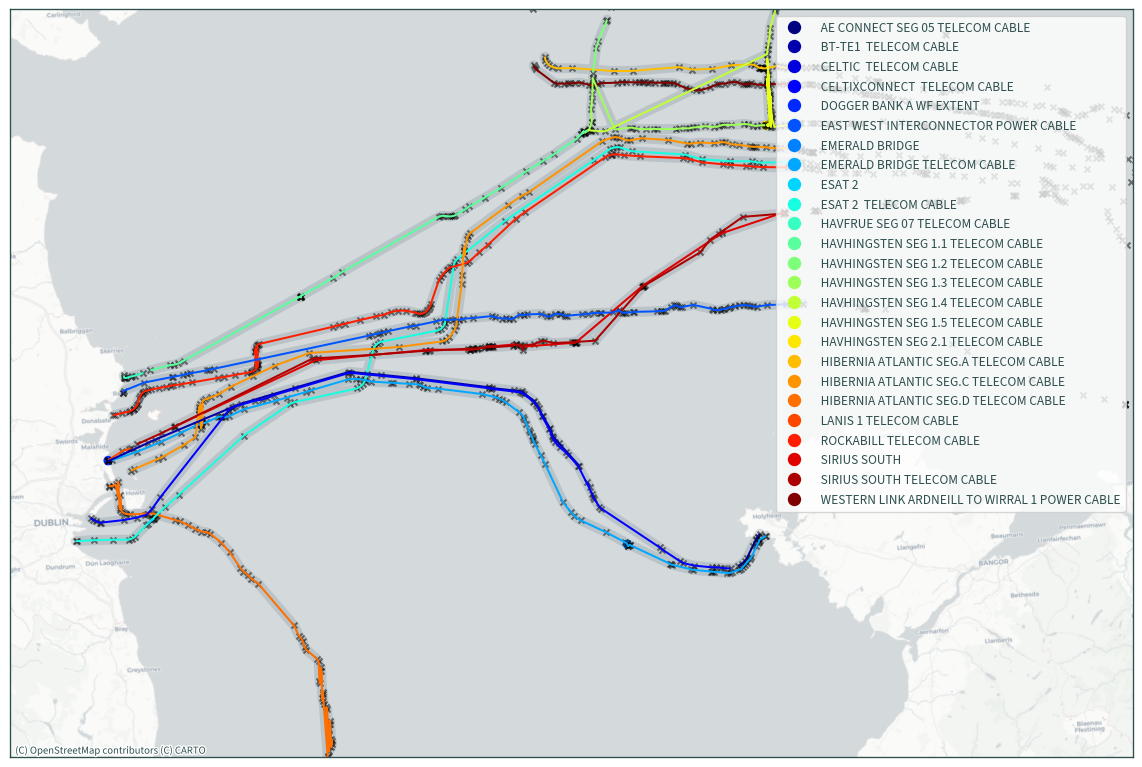

In [75]:
ax = gpd.GeoDataFrame(
    geometry=data_ie.to_crs(23029).buffer(750)
).dissolve().plot(figsize=(12, 12), alpha=.25, color="slategrey")
data_ie.to_crs(23029).plot(
    column="name", legend=True, ax=ax, cmap="jet",
    legend_kwds={"loc": "upper right"}
)
data.to_crs(23029).plot(
    ax=ax, marker="x", color="black", markersize=20, alpha=.5
)
plt.xlim(xmin - 10000, xmax + 50000)
plt.ylim(ymin, ymax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=23029)
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [56]:
data_ie.to_file(os.path.join(DATA_DIR, "KIS-ORCA.gpkg"))